In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.trainfull3d_labels import *

Loading imports


In [2]:
torch.cuda.set_device(4)

In [3]:
dls = get_3d_dls_aug(Meta.df_comb, sz=128, bs=32, grps=Meta.grps_stg1)

## Model

In [4]:
def get_3d_head(p=0.0):
    pool, feat = (nn.AdaptiveAvgPool3d(1), 64)
    m = nn.Sequential(Batchify(),
        ConvLayer(512,512,stride=2,ndim=3), # 8
        ConvLayer(512,1024,stride=2,ndim=3), # 4
        ConvLayer(1024,1024,stride=2,ndim=3), # 2
        nn.AdaptiveAvgPool3d((1, 1, 1)), Batchify(), Flat3d(), nn.Dropout(p),
        nn.Linear(1024, 6))
    init_cnn(m)
    return m

In [5]:
m = get_3d_head()
config=dict(custom_head=m)
learn = get_learner(dls, xresnet18, get_loss(), config=config)

In [6]:
hook = ReshapeBodyHook(learn.model[0])
learn.add_cb(RowLoss())

In [7]:
# learn.load(f'runs/baseline_stg1_xresnet18-3', strict=False)

In [8]:
name = 'trainfull3d_labels_partial3d'

## Training

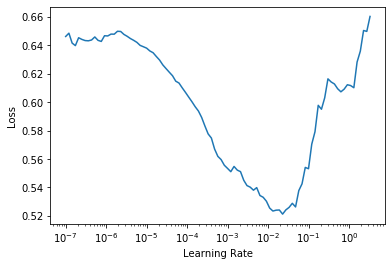

In [9]:
learn.lr_find()

In [18]:
do_fit(learn, 12, 1e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.347374,0.407193,0.852529,0.771454,10:42
1,0.314710,0.549691,0.848238,0.757453,09:37
2,0.280744,0.394829,0.847260,0.767841,09:44
3,0.271222,0.335677,0.876242,0.849142,09:38
4,0.246964,0.369280,0.852680,0.726739,09:35
5,0.246933,0.343405,0.877296,0.833333,09:36
6,0.225976,0.264974,0.899804,0.881662,09:33
7,0.215772,0.287276,0.889943,0.864047,09:33
8,0.206779,0.251388,0.905450,0.886179,09:34
9,0.198638,0.251419,0.908311,0.889341,09:39


In [ ]:
learn.load(f'runs/{name}-1')
learn.dls = get_3d_dls_aug(Meta.df_comb, sz=256, bs=12, grps=Meta.grps_stg1)
do_fit(learn, 12, 1e-3)
learn.save(f'runs/{name}-2')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.260014,0.285586,0.891298,0.862240,26:05
1,0.227288,0.267590,0.900934,0.882114,25:47


In [ ]:
learn.load(f'runs/{name}-2')
learn.dls = get_3d_dls_aug(Meta.df_comb, sz=384, bs=4, path=path_jpg, grps=Meta.grps_stg1)
do_fit(learn, 4, 1e-4)
learn.save(f'runs/{name}-3')